# Yolo Demo

В данном примере реализован следующий алгоритм:

1. Получаем эмбединги для текстового запроса с помощью модели Clip
2. Среди предпосчитанных эмбедингов для кропов находим наиболее похожие на вектор из п.1 (в данном ноутбуке работает brute-force -- предыдущая реализация Annoy работала недостаточно хорошо и пропускала часть значимых результатов или могла долго работать. В случае использования ANN алгоритмов стоит уделить большее внимание на гиперпараметры и качество работы таких алгоритмов)
3. Берем топ-9 кропов, находим для них соответствующие картинки
4. Дополнительно находим кропы с Cosine similarity больше порога (0.25 - хорошие, 0.3 - отличные)
5. Визуализируем найденные кропы на картинках 

In [1]:
import sys

sys.path.append("./yolov5")

In [8]:
import os

import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
from assh_utils import Batch, dump_pickle, get_iou, load_json, load_pickle, nms
from tqdm.notebook import tqdm
from yolo_utils import CustomWrapper, DetectMultiBackend

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
%matplotlib inline

cpu


In [3]:
TRH_EXTRA = 0.24

images = pd.read_pickle("/home/asciishell/s3/asciishell-fsod/RunYoloV2/train.done.pkl.zip")

# model = CustomWrapper(DetectMultiBackend("./yolov5l.pt", device=device))

clip_model, clip_preprocess = clip.load("/home/asciishell/s3/asciishell-fsod/models/ViT-B-32.pt", device)

index = np.load("/home/asciishell/s3/asciishell-fsod/RunYoloV2/train_emb.npy")

Fusing layers... 
Model Summary: 367 layers, 46533693 parameters, 0 gradients
Adding AutoShape... 


In [4]:
def get_vector_text(x):
    text_inputs = torch.cat([clip.tokenize(x)]).to(device)
    with torch.no_grad():
        text_features = clip_model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features[0].cpu().numpy()


def get_vector_image(x):
    img = PIL.Image.open(x)
    img.thumbnail((640, 640), PIL.Image.ANTIALIAS)
    img.show()
    image_input = clip_preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features[0].cpu().numpy()


def get_vector_image2(img):
    img.show()
    image_input = clip_preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features[0].cpu().numpy()

In [5]:
def cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


def cos_sim_matrix(a, b):
    return np.dot(a, b) / np.linalg.norm(b)


def get_ns_by_vector(vec, n):
    vec = vec.astype(np.float16)
    dist = cos_sim_matrix(index, vec)
    idx = np.argsort(dist)
    top_idx = idx[: -n - 1 : -1]
    return top_idx, dist[top_idx], dist

In [6]:
text = "sport person"
idx, dist, all_dist = get_ns_by_vector(get_vector_text(text), 9)
images_to_display = images.loc[idx].assign(dist=dist).copy()

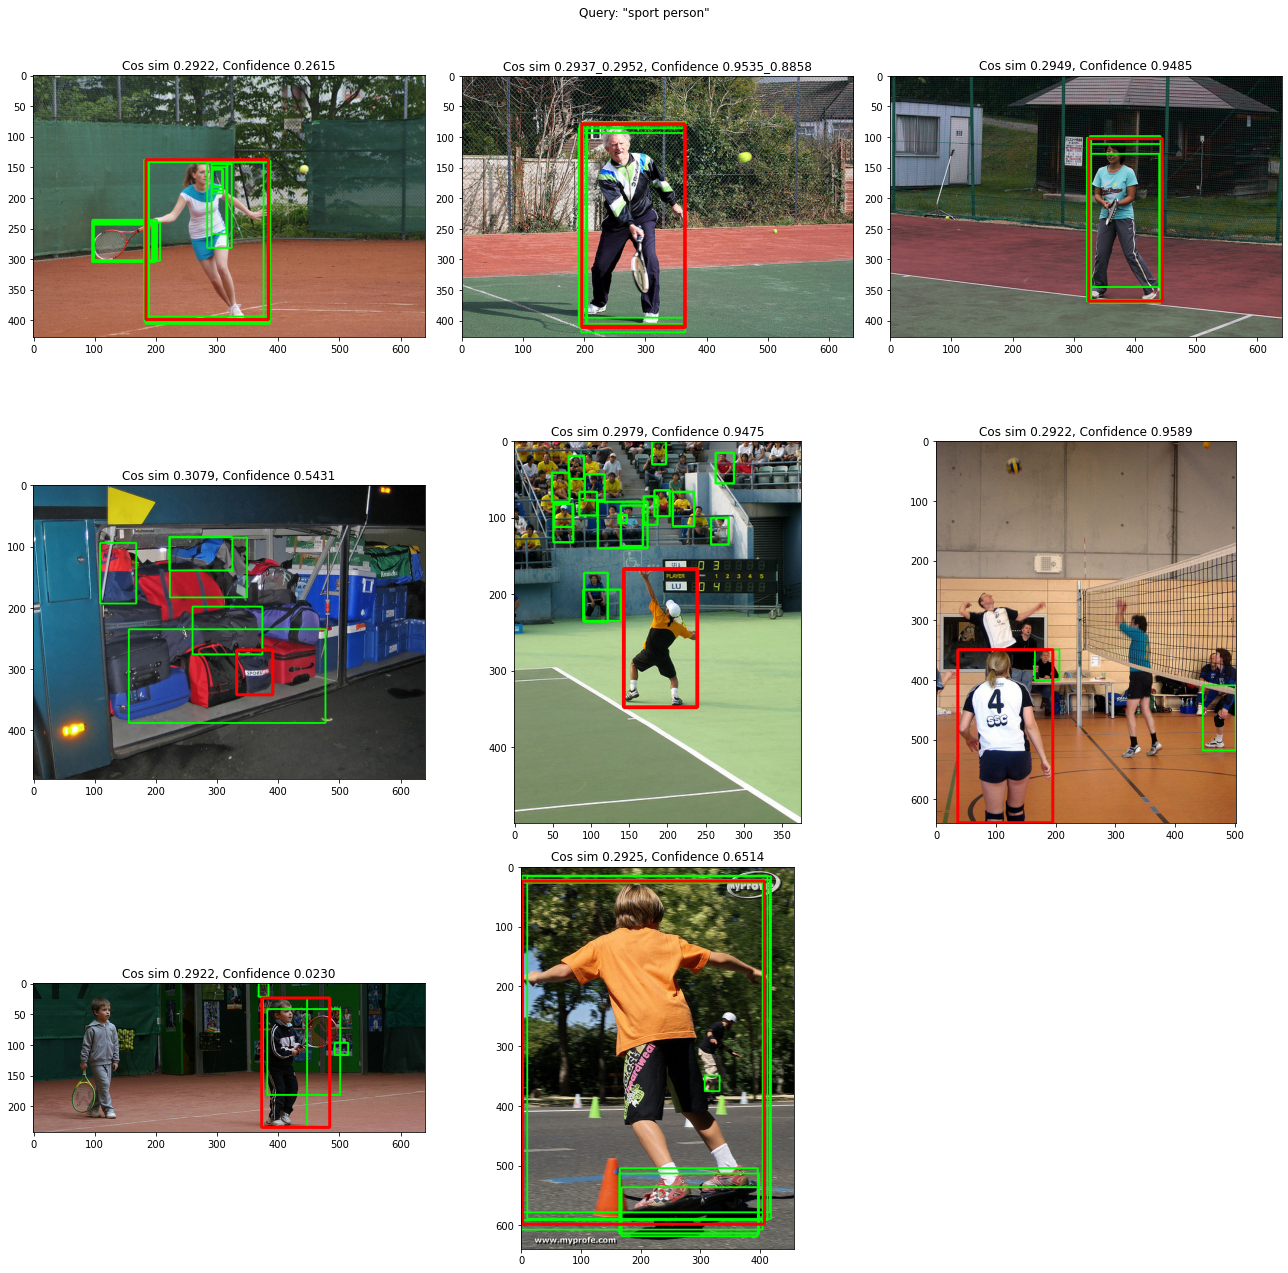

In [10]:
plt.figure(figsize=(18, 18), facecolor="w")
for i, (img, meta) in enumerate(images_to_display.sort_values("dist").groupby("image")):
    img_same = images[(images["image"] == img)].copy()
    img_same["dist"] = all_dist[img_same.index]
    img_same = img_same[(img_same["dist"] > TRH_EXTRA) & (~img_same.index.isin(meta.index))]

    image = cv2.imread(img.replace("/home/jupyter/mnt", "/home/asciishell"), cv2.IMREAD_COLOR)
    assert image is not None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for _, row in img_same.iterrows():
        image = cv2.rectangle(
            image,
            (row["xmin"], row["ymin"]),
            (row["xmax"], row["ymax"]),
            (0, 255, 0),
            2,
        )
    for _, row in meta.iterrows():
        image = cv2.rectangle(
            image,
            (row["xmin"], row["ymin"]),
            (row["xmax"], row["ymax"]),
            (255, 0, 0),
            3,
        )
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    dists = "_".join(["{:.4f}".format(x) for x in meta["dist"]])
    confs = "_".join(["{:.4f}".format(x) for x in meta["confidence"]])
    plt.title(f"Cos sim {dists}, Confidence {confs}")
plt.suptitle(f'Query: "{text}"')
plt.tight_layout()
plt.show()